In [616]:
import sys
sys.path.append('../scripts/')

In [617]:
from conn import connection
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [618]:
query = """
select
    c.customer_unique_id,
    max(o.order_purchase_timestamp) as last_order_time,
    count(distinct o.order_id) as frequency,
    round(sum(payments.payment_value),2) as monetary_value,
    c.customer_city
from customers c
join orders o on c.customer_id = o.customer_id
join payments on o.order_id = payments.order_id
group by c.customer_unique_id, c.customer_city, c.customer_state;
"""

In [619]:
engine = connection()
df = pd.read_sql(query, engine)

Connection success


In [620]:
df['last_order_time'] = pd.to_datetime(df['last_order_time'])

In [621]:
df['customer_city'] = df['customer_city'].str.title()

## RFM (Recency, Frequency, Monetary) analysis

In [623]:
reference_date = df['last_order_time'].max() + pd.Timedelta(days=1)

In [624]:
df['recency'] = (reference_date - df['last_order_time']).dt.days

In [625]:
# assigning scores to the customers on reference to RFM.

df['r_score'] = pd.qcut(df['recency'], 5, labels=[5,4,3,2,1])
df['f_score'] = pd.qcut(df['frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
df['m_score'] = pd.qcut(df['monetary_value'].rank(method='first'), 5, labels=[1,2,3,4,5])

In [626]:
df['rfm_score'] = df['r_score'].astype(str) + df['f_score'].astype(str) + df['m_score'].astype(str)
df['rfm_total'] = df[['r_score', 'f_score', 'm_score']].sum(axis=1)

In [627]:
def segment_customer(row):
    if row['rfm_score'] == '555':
        return 'Top Customer'
    elif row['r_score'] == 5:
        return 'Active Customer'
    elif row['f_score'] == 5:
        return 'Loyal Customer'
    elif row['m_score'] == 5:
        return 'Big Spender'
    elif row['rfm_total'] <= 6:
        return 'Lost'
    else:
        return 'Others'

In [628]:
df['segment'] = df.apply(segment_customer, axis=1)

In [629]:
segment_values = df['segment'].value_counts()
segment_values

segment
Others             34090
Active Customer    18282
Lost               15872
Loyal Customer     15302
Big Spender        11625
Top Customer        1047
Name: count, dtype: int64

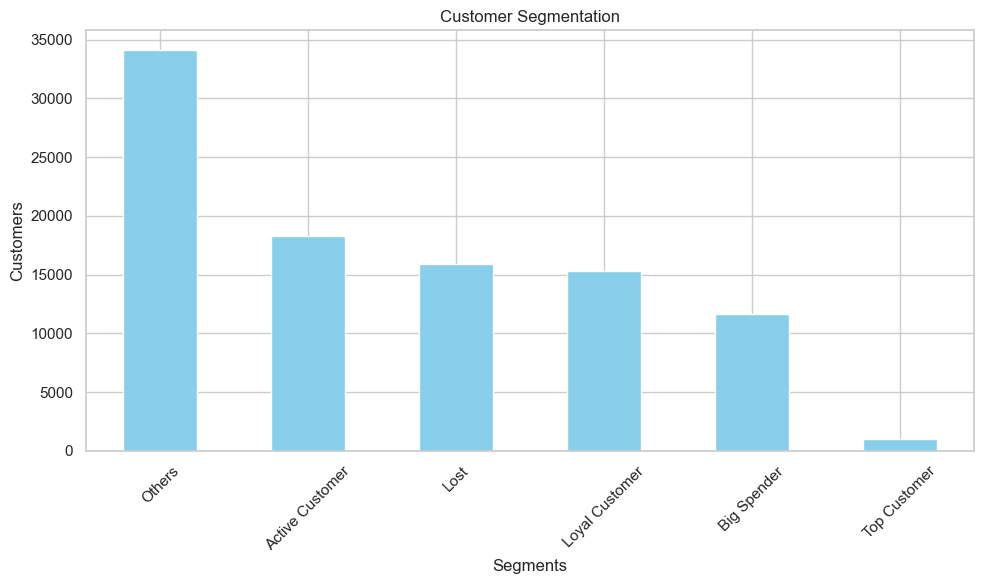

In [630]:
plt.figure(figsize=(10,6))
segment_values.plot(kind='bar', color='skyblue')

plt.title('Customer Segmentation')
plt.xlabel('Segments')
plt.ylabel('Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Loyal customers by city/state

In [632]:
loyals = df[df['segment'] == 'Loyal Customer']
loyals_by_city = loyals['customer_city'].value_counts().head(10)
loyals_by_city = loyals_by_city.head(10)
loyals_by_city

customer_city
Sao Paulo         2338
Rio De Janeiro    1124
Belo Horizonte     440
Brasilia           340
Curitiba           229
Porto Alegre       212
Campinas           207
Salvador           174
Guarulhos          167
Niteroi            143
Name: count, dtype: int64

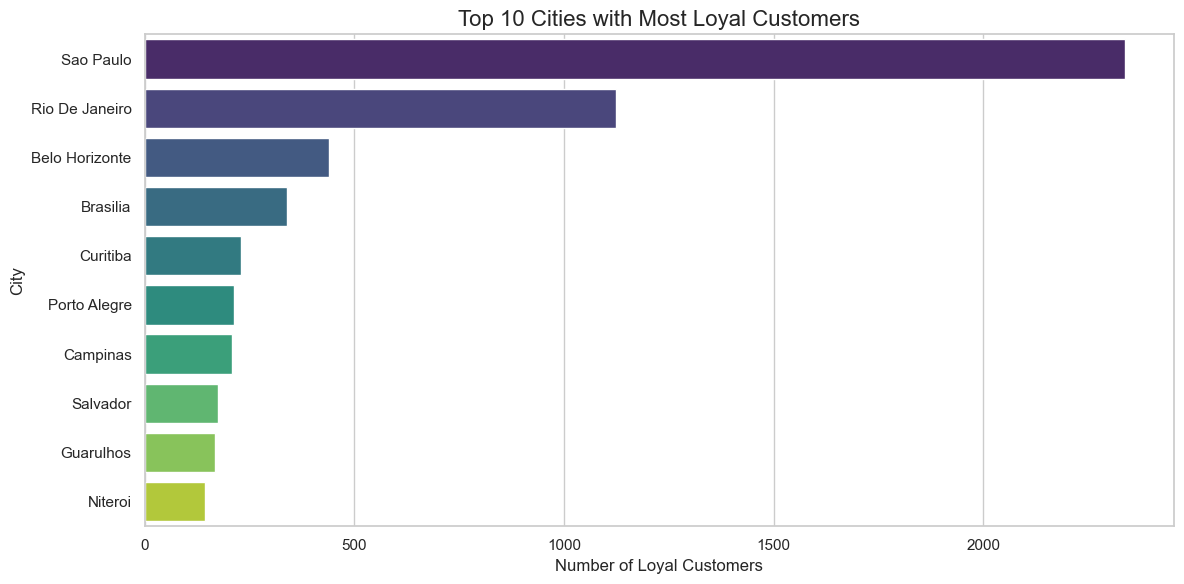

In [633]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.barplot(
    x=loyals_by_city.values,
    y=loyals_by_city.index,
    palette="viridis"
)
plt.title("Top 10 Cities with Most Loyal Customers", fontsize=16)
plt.xlabel("Number of Loyal Customers")
plt.ylabel("City")

plt.tight_layout()
plt.show()